# Interactive Diagram Generator
This notebook generates interactive diagrams for AL to be loaded into FlyBrainLab.

In [1]:
import networkx as nx
import numpy as np

target_glom = 'DL5' # glomerulus to use
G = nx.read_gexf('hemibrain_AL_ctype_level.gexf')

Unique Groups: ['0000' '0001' '0010' '0011' '0100' '0101' '0110' '0111' '1000' '1011'
 '1100' '1111']


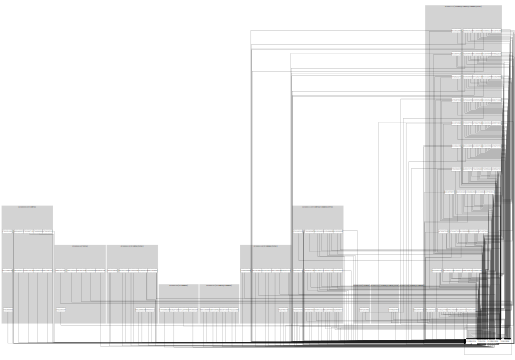

In [2]:
subnodes = []
for i in G.nodes():
    if (('PNs' in i) or ('ORNs' in i)) and target_glom+' ' not in i:
        pass
    else:
        subnodes.append(i)
SG = G.subgraph(subnodes)

Gmap = {}
for i in G.nodes():
    if i.isnumeric():
        Gmap[i] = ['0','0','0','0']
        if SG.has_edge(i, target_glom+' ORNs'):
            Gmap[i][0] = '1'
        if SG.has_edge(i, target_glom+' PNs'):
            Gmap[i][2] = '1'
        if SG.has_edge(target_glom+' ORNs', i):
            Gmap[i][1] = '1'
        if SG.has_edge(target_glom+' PNs', i):
            Gmap[i][3] = '1'
            
unique_groups = np.unique([''.join(i) for i in list(Gmap.values())])
print('Unique Groups:', unique_groups)

from graphviz import Digraph

g = Digraph('G', filename='my_graphviz.gv', format='svg')
g.attr(splines='ortho', overlap='prism', overlap_scaling='0.001', ratio='0.7', size='10,5', pad='0.1', nodesep='0.02', ranksep='0.01')
with g.subgraph(name='cluster_default') as c:
    c.node_attr.update(style='filled', color='white', shape='box')
    c.node('To '+target_glom+' ORNs')
    c.node('To '+target_glom+' PNs')
    c.node('From '+target_glom+' ORNs')
    c.node('From '+target_glom+' PNs')
    
valid_LNs = []
node_conn = {}
for i in range(len(unique_groups)):
    unique_group = unique_groups[i]
    with g.subgraph(name='cluster_'+str(i)) as c:
        
        c.attr(style='filled', color='lightgrey')
        c.node_attr.update(style='filled,dashed', fillcolor='white', shape='box')
        subgraph_nodes = []
        master_node = None
        group_text = 'None'
        for j in Gmap.keys():
            if ''.join(Gmap[j]) == unique_group and unique_group != '0000':
                # node_name = j + ' :: ' + ','.join(list(SG.predecessors(j)))[:5]
                node_conn[j] = list(set(list(SG.predecessors(j)) + list(SG.successors(j))))
                node_name = j
                c.node(node_name, label=j)
                valid_LNs.append(j)
                subgraph_nodes.append(j)
                if len(subgraph_nodes) % 5 == 0:
                    if master_node is not None:
                        c.edge(master_node, node_name, style='invis')
                    master_node = node_name
                group_text = ''
                if master_node is not None:
                    c.edge(master_node, node_name, style='invis')
                if SG.has_edge(j, target_glom+' ORNs'):
                    c.edges([(node_name, 'To '+target_glom+' ORNs')])
                    group_text += ',To ORNs'
                if SG.has_edge(target_glom+' PNs', j):
                    c.edges([(node_name, 'From '+target_glom+' PNs')])
                    group_text += ',From PNs'
                if SG.has_edge(target_glom+' ORNs', j):
                    c.edges([(node_name, 'From '+target_glom+' ORNs')])
                    group_text += ',From ORNs'
                if SG.has_edge(j, target_glom+' PNs'):
                    c.edges([(node_name, 'To '+target_glom+' PNs')])
                    group_text += ',To PNs'
        c.attr(label='Group '+unique_group+' ('+group_text[1:]+')')

import json 
json_object = 'window.additional_conn = ' + json.dumps(node_conn, indent = 4) + ';'
with open('additional_conn.js','w') as f:
    f.write(json_object)
        
g.save('G_glom.gv')
g.render('G_glom', view=False)
g